####Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import io
from collections import defaultdict, deque
import datetime
import torch.distributed as dist
import math
import sys
import copy
import cv2
from google.colab.patches import cv2_imshow
from pycocotools.cocoeval import COCOeval
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#COCO api
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


#Augmentations
! pip install --upgrade albumentations
import albumentations as A
import cv2

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')





Mounted at /content/gdrive


In [ ]:
#train
dataDir='/content/gdrive/My Drive/Phase Project/COCO'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco =COCO(annFile)
#val
dataDir='/content/gdrive/My Drive/Phase Project/COCO'
dataType2='val2017'
annFile2='{}/annotations/instances_{}.json'.format(dataDir,dataType2)
coco2 = COCO(annFile2)

loading annotations into memory...
Done (t=23.40s)
creating index...
index created!
loading annotations into memory...
Done (t=1.57s)
creating index...
index created!


#Dataset 

In [ ]:
from torch.utils.data import Dataset

class COCODataset(Dataset):
  def __init__(self, coco, catNms, transform = None):
    self.coco = coco
    self.transform = transform
    self.catIds = coco.getCatIds(catNms=catNms)
    self.imgIds = coco.getImgIds(catIds = catIds)

  def __len__(self):
     return len(self.imgIds)

  def __getitem__(self, index):
      
      coco = self.coco
      imgIds = self.imgIds
      catIds = self.catIds
      img_id = imgIds[index]
      #print('ID',index)
      targets = []
      #image
      i = coco.loadImgs(img_id)[0]
      img = io.imread(i['coco_url'])

      #annotations
      annIds = coco.getAnnIds(imgIds=i['id'], catIds = catIds, iscrowd =False)
      coco_annotation = coco.loadAnns(annIds)

      #print(coco_annotation.shape)
      num_objs = len(coco_annotation)
      #print('num_objs:', num_objs)
      boxes = []
      labels = []
      is_crowd = []
      for i in range(num_objs):
          xmin = coco_annotation[i]["bbox"][0]
          ymin = coco_annotation[i]["bbox"][1]
          xmax = xmin + coco_annotation[i]["bbox"][2] +0.01
          ymax = ymin + coco_annotation[i]["bbox"][3] +0.01
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append(torch.as_tensor(coco_annotation[i]["category_id"], dtype=torch.int64))
          is_crowd.append(torch.as_tensor(coco_annotation[i]["iscrowd"], dtype=torch.int64))
      boxes = torch.as_tensor(boxes, dtype=torch.int64)
        # Labels (In my case, I only one class: target class or background)
      #labels = torch.as_tensor(labels, dtype=torch.int64)
      #print('Labels', labels)
        # Tensorise img_id
      img_id = torch.tensor(img_id)
        # Size of bbox (Rectangular)
      areas = []
      for i in range(num_objs):
          areas.append(coco_annotation[i]["area"])
      areas = torch.as_tensor(areas, dtype=torch.float32)

      #Annotations to dictionary

      my_annotation = {}
      my_annotation["boxes"] = boxes
      my_annotation["labels"] = labels
      my_annotation["image_id"] = img_id
      my_annotation["area"] = areas
      my_annotation["iscrowd"] = is_crowd
      
      sample = (img, my_annotation)

      if self.transform:
         sample = self.transform(sample)
         img, my_annotation = sample[0], sample[1]
      temp1 = my_annotation['boxes']
      if temp1 != []:
        if len(temp1) == 1:
          my_annotation['boxes'] = torch.stack(temp1)
        else:
          my_annotation['boxes'] = torch.stack(temp1).squeeze(0)
      else:
        my_annotation['boxes'] = torch.empty(0,4)
      #print(my_annotation['boxes'])
      temp3 =  my_annotation['labels']
      #temp3 = torch.Tensor(temp3, dtype = torch.int64)
      my_annotation['labels'] = torch.as_tensor(np.asarray(temp3), dtype = torch.int64)
      #for i in range(my_annotation['labels'].shape[0]):
       # if my_annotation['labels'][i] == 3:
        #  my_annotation['labels'][i] = 2
      #print(my_annotation['labels'])
      #print(my_annotation['boxes'].shape)
      temp4 = my_annotation['area']
      my_annotation['area']  = torch.from_numpy(np.asarray(temp3))
      temp4 = my_annotation["iscrowd"]
      my_annotation["iscrowd"] = torch.as_tensor(np.asarray(temp4), dtype = torch.int64)
      targets.append(my_annotation)
      return img, my_annotation


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
        

    def __call__(self,sample):
        img , annotations = sample[0], sample[1]
        image = transforms.ToTensor()(img)
        #for i in range(len(anno['boxes'])):

        for i in range(len(annotations['boxes'])):
          temp = annotations['boxes'][i]
          box = torch.tensor([temp[0].item(), temp[1].item(), temp[2].item()+0.01, temp[3].item()+0.01])
          annotations['boxes'][i] = box

        return image, annotations

class Resize_Img_Bbox(object):

    def __call__(self, sample):
        img , myannotation = sample[0], sample[1]
        M = myannotation["boxes"]
        K = myannotation["labels"]
        #print(K[0])
        L = myannotation["area"]
        aug = A.Compose([A.Resize(height=512, width=512),
                         ], bbox_params=A.BboxParams(format='pascal_voc', min_area = 512, label_fields=['class_labels', 'area']))
        result = aug(image=img, bboxes = M, class_labels = K, area = L)
        img = result['image']
        myannotation["boxes"] = result['bboxes']
        myannotation["labels"] = result['class_labels']
        myannotation["area"] = result['area']
        #sample = (img, myannotation)
        return img, myannotation



In [ ]:
nms = {}
cats = coco.loadCats(coco.getCatIds())
for cat in cats:
  nms[str(cat['id'])] = cat['name']
nms

{'1': 'person',
 '10': 'traffic light',
 '11': 'fire hydrant',
 '13': 'stop sign',
 '14': 'parking meter',
 '15': 'bench',
 '16': 'bird',
 '17': 'cat',
 '18': 'dog',
 '19': 'horse',
 '2': 'bicycle',
 '20': 'sheep',
 '21': 'cow',
 '22': 'elephant',
 '23': 'bear',
 '24': 'zebra',
 '25': 'giraffe',
 '27': 'backpack',
 '28': 'umbrella',
 '3': 'car',
 '31': 'handbag',
 '32': 'tie',
 '33': 'suitcase',
 '34': 'frisbee',
 '35': 'skis',
 '36': 'snowboard',
 '37': 'sports ball',
 '38': 'kite',
 '39': 'baseball bat',
 '4': 'motorcycle',
 '40': 'baseball glove',
 '41': 'skateboard',
 '42': 'surfboard',
 '43': 'tennis racket',
 '44': 'bottle',
 '46': 'wine glass',
 '47': 'cup',
 '48': 'fork',
 '49': 'knife',
 '5': 'airplane',
 '50': 'spoon',
 '51': 'bowl',
 '52': 'banana',
 '53': 'apple',
 '54': 'sandwich',
 '55': 'orange',
 '56': 'broccoli',
 '57': 'carrot',
 '58': 'hot dog',
 '59': 'pizza',
 '6': 'bus',
 '60': 'donut',
 '61': 'cake',
 '62': 'chair',
 '63': 'couch',
 '64': 'potted plant',
 '65': '

In [ ]:
catNms = ['person', 'car', 'bicycle']
catIds = coco.getCatIds(catNms=catNms)
imgIds = coco.getImgIds(catIds = catIds)
img_id = imgIds[5]
i = coco.loadImgs(img_id)[0]
annIds = coco.getAnnIds(imgIds=i['id'], catIds = catIds, iscrowd =False)
coco_annotation = coco.loadAnns(annIds)
len(imgIds)

1101

In [ ]:
import PIL
from PIL.Image import BICUBIC
from PIL import Image

transform_train = transforms.Compose([Resize_Img_Bbox(),
                                      ToTensor(),    
                                      
                            
])
def collate_fn(batch):
    return tuple(zip(*batch))

trainset = COCODataset(coco, catNms, transform = transform_train)
valset = COCODataset(coco2, catNms,  transform = transform_train)
train = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2, collate_fn=collate_fn)
val = DataLoader(valset, batch_size = 4, shuffle = True, num_workers = 2, collate_fn = collate_fn)

###Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['bicycle', 'car', 'person']


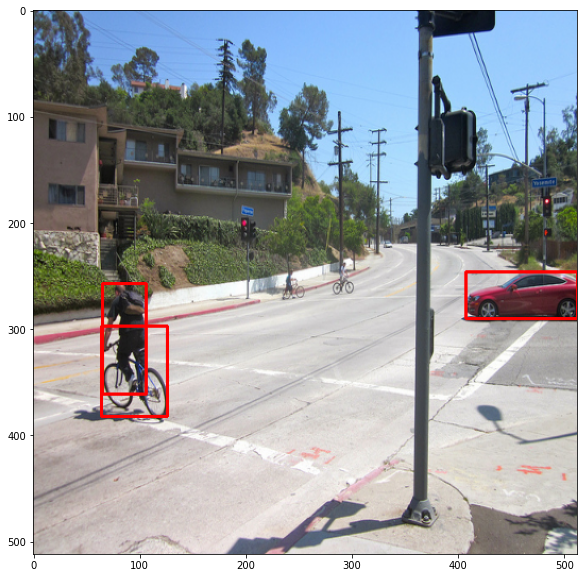

In [ ]:
dataiter = iter(train)
imgg, anno = dataiter.next()
img = imgg[0].permute(1,2,0)
plt.figure(figsize=(10  ,10))
plt.imshow(img)
bboximg = img.numpy().copy()
anno[0]['boxes'] = anno[0]['boxes'].squeeze(0)
anno[0]['labels'] = anno[0]['labels'].squeeze(0)
nms = {}
nms['1'] = 'person'
nms['2'] = 'bicycle'
nms['3'] = 'car'
for annot in anno[0]['boxes']:
  xmin = int(annot[0].item())
  ymin = int(annot[1].item())
  xmax = int(annot[2].item())
  ymax = int(annot[3].item())
  cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (255,0, 0), 2)
plt.imshow(bboximg)
labels = [nms[str(x.item())] for x in anno[0]['labels']]
print(labels)

#Model building

##I. Pre-trained R-*ISONet* - To be used as a backbone in FasterRcNN detector-to remove head and extract feature maps 

In [ ]:


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Stage depths for ImageNet models
_IN_STAGE_DS = {
    18: (2, 2, 2, 2),
    34: (3, 4, 6, 3),
    46: (3, 4, 12, 3),
    50: (3, 4, 6, 3),
    101: (3, 4, 23, 3),
    152: (3, 8, 36, 3),
}


def get_trans_fun(name):
    """Retrieves the transformation function by name."""
    trans_funs = {
        'basic_transform': BasicTransform,
        'bottleneck_transform': BottleneckTransform,
    }
    assert name in trans_funs.keys(), \
        'Transformation function \'{}\' not supported'.format(name)
    return trans_funs[name]


class SReLU(nn.Module):
    """Shifted ReLU"""

    def __init__(self, nc):
        super(SReLU, self).__init__()
        self.srelu_bias = nn.Parameter(torch.Tensor(1, nc, 1, 1))
        self.srelu_relu = nn.ReLU(inplace=True)
        nn.init.constant_(self.srelu_bias, -1.0) #Fills the input Tensor with the value Val .

    def forward(self, x):
        return self.srelu_relu(x - self.srelu_bias) + self.srelu_bias


class SharedScale(nn.Module):
    """Channel-shared scalar"""
    def __init__(self):
        super(SharedScale, self).__init__()
        self.scale = nn.Parameter(torch.ones(1, 1, 1, 1) * 1.0)

    def forward(self, x):
        return x * self.scale




class BasicTransform(nn.Module):
    """Basic transformation: 3x3, 3x3"""

    def __init__(self, w_in, w_out, stride, w_b=None, num_gs=1):
        assert w_b is None and num_gs == 1, \
            'Basic transform does not support w_b and num_gs options'
        super(BasicTransform, self).__init__()
        self._construct(w_in, w_out, stride)

    def _construct(self, w_in, w_out, stride):
        # 3x3, BN, ReLU
        self.a = nn.Conv2d(
            w_in, w_out, kernel_size=3,
            stride=stride, padding=1, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.a_bn = nn.BatchNorm2d(w_out)
        self.a_relu = nn.ReLU(inplace=True) if not SReLU_ else SReLU(w_out)
        # 3x3, BN
        self.b = nn.Conv2d(
            w_out, w_out, kernel_size=3,
            stride=1, padding=1, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.b_bn = nn.BatchNorm2d(w_out)
            self.b_bn.final_bn = True

        if HAS_RES_MULTIPLIER:
            self.shared_scalar = SharedScale()

    def forward(self, x):
        for layer in self.children():
            x = layer(x)
        return x


class BottleneckTransform(nn.Module):
    """Bottleneck transformation: 1x1, 3x3, 1x1"""

    def __init__(self, w_in, w_out, stride, w_b, num_gs):
        super(BottleneckTransform, self).__init__()
        self._construct(w_in, w_out, stride, w_b, num_gs)

    def _construct(self, w_in, w_out, stride, w_b, num_gs):
        # MSRA -> stride=2 is on 1x1; TH/C2 -> stride=2 is on 3x3
        (str1x1, str3x3) = (1, stride)
        # 1x1, BN, ReLU
        self.a = nn.Conv2d(
            w_in, w_b, kernel_size=1,
            stride=str1x1, padding=0, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.a_bn = nn.BatchNorm2d(w_b)
        self.a_relu = nn.ReLU(inplace=True) if not SReLU_ else SReLU(w_b)
        # 3x3, BN, ReLU
        self.b = nn.Conv2d(
            w_b, w_b, kernel_size=3,
            stride=str3x3, padding=1, groups=num_gs, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.b_bn = nn.BatchNorm2d(w_b)
        self.b_relu = nn.ReLU(inplace=True) if not SReLU_ else SReLU(w_b)
        # 1x1, BN
        self.c = nn.Conv2d(
            w_b, w_out, kernel_size=1,
            stride=1, padding=0, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.c_bn = nn.BatchNorm2d(w_out)
            self.c_bn.final_bn = True

        if HAS_RES_MULTIPLIER:
            self.shared_scalar = SharedScale()

    def forward(self, x):
        for layer in self.children():
            x = layer(x)
        return x


class ResBlock(nn.Module):
    """Residual block: x + F(x)"""

    def __init__(
        self, w_in, w_out, stride, trans_fun, w_b=None, num_gs=1
    ):
        super(ResBlock, self).__init__()
        self._construct(w_in, w_out, stride, trans_fun, w_b, num_gs)

    def _add_skip_proj(self, w_in, w_out, stride):
        self.proj = nn.Conv2d(
            w_in, w_out, kernel_size=1,
            stride=stride, padding=0, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.bn = nn.BatchNorm2d(w_out)

    def _construct(self, w_in, w_out, stride, trans_fun, w_b, num_gs):
        # Use skip connection with projection if shape changes
        self.proj_block = (w_in != w_out) or (stride != 1)
        if self.proj_block and HAS_ST:
            self._add_skip_proj(w_in, w_out, stride)
        self.f = trans_fun(w_in, w_out, stride, w_b, num_gs)
        self.relu = nn.ReLU(True) if not SReLU_ else SReLU(w_out)

    def forward(self, x):
        if self.proj_block:
            if HAS_BN and HAS_ST:
                x = self.bn(self.proj(x)) + self.f(x)
            elif not HAS_BN and HAS_ST:
                x = self.proj(x) + self.f(x)
            else:
                x = self.f(x)
        else:
            if HAS_ST:
                x = x + self.f(x)
            else:
                x = self.f(x)
        x = self.relu(x)
        return x


class ResStage(nn.Module):
    """Stage of ResNet."""

    def __init__(self, w_in, w_out, stride, d, w_b=None, num_gs=1):
        super(ResStage, self).__init__()
        self._construct(w_in, w_out, stride, d, w_b, num_gs)

    def _construct(self, w_in, w_out, stride, d, w_b, num_gs):
        # Construct the blocks
        for i in range(d):
            # Stride and w_in apply to the first block of the stage
            b_stride = stride if i == 0 else 1
            b_w_in = w_in if i == 0 else w_out
            # Retrieve the transformation function
            trans_fun = get_trans_fun(TRANS_FUN)
            # Construct the block
            res_block = ResBlock(
                b_w_in, w_out, b_stride, trans_fun, w_b, num_gs
            )
            self.add_module('b{}'.format(i + 1), res_block)

    def forward(self, x):
        for block in self.children():
            x = block(x)
        return x


class ResStem(nn.Module):
    """Stem of ResNet."""

    def __init__(self, w_in, w_out):
        super(ResStem, self).__init__()
        if 'CIFAR' in DATASET_NAME:
            self._construct_cifar(w_in, w_out)
        else:
            self._construct_imagenet(w_in, w_out)

    def _construct_cifar(self, w_in, w_out):
        # 3x3, BN, ReLU
        self.conv = nn.Conv2d(
            w_in, w_out, kernel_size=3,
            stride=1, padding=1, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.bn = nn.BatchNorm2d(w_out)
        self.relu = nn.ReLU(inplace = True) if not SReLU_ else SReLU(w_out)

    def _construct_imagenet(self, w_in, w_out):
        # 7x7, BN, ReLU, maxpool
        self.conv = nn.Conv2d(
            w_in, w_out, kernel_size=7,
            stride=2, padding=3, bias=not HAS_BN and not SReLU_
        )
        if HAS_BN:
            self.bn = nn.BatchNorm2d(w_out)
        self.relu = nn.ReLU(inplace = True) if not SReLU_ else SReLU(w_out)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        for layer in self.children():
            x = layer(x)
        return x


class ISONet(nn.Module):
    """ResNet model."""

    def __init__(self):
        super(ISONet, self).__init__()
        # define network structures
        if 'CIFAR' in DATASET_NAME:
            self._construct_cifar()
        elif TRANS_FUN == 'basic_transform':
            self._construct_imagenet_basic()
        elif TRANS_FUN == 'bottleneck_transform':
            self._construct_imagenet()
        else:
            raise NotImplementedError
        # initialization
        self._network_init()

    def _construct_cifar(self):
        assert (DEPTH - 2) % 6 == 0, \
            'Model depth should be of the format 6n + 2 for cifar'
        # Each stage has the same number of blocks for cifar
        d = int((DEPTH - 2) / 6)
        # Stem: (N, 3, 32, 32) -> (N, 16, 32, 32)
        self.stem = ResStem(w_in=3, w_out=16)
        # Stage 1: (N, 16, 32, 32) -> (N, 16, 32, 32)
        self.s1 = ResStage(w_in=16, w_out=16, stride=1, d=d)
        # Stage 2: (N, 16, 32, 32) -> (N, 32, 16, 16)
        self.s2 = ResStage(w_in=16, w_out=32, stride=2, d=d)
        # Stage 3: (N, 32, 16, 16) -> (N, 64, 8, 8)
        self.s3 = ResStage(w_in=32, w_out=64, stride=2, d=d)
        # Head: (N, 64, 8, 8) -> (N, num_classes)
        self.head = ResHead(w_in=64, nc=NUM_CLASSES)

    def _construct_imagenet_basic(self):
        # Retrieve the number of blocks per stage
        (d1, d2, d3, d4) = _IN_STAGE_DS[DEPTH]
        # Compute the initial bottleneck width
        # Stem: (N, 3, 224, 224) -> (N, 64, 56, 56)
        self.stem = ResStem(w_in=3, w_out=64)
        # Stage 1: (N, 64, 56, 56) -> (N, 256, 56, 56)
        self.s1 = ResStage(w_in=64, w_out=64, stride=1, d=d1)
        # Stage 2: (N, 256, 56, 56) -> (N, 512, 28, 28)
        self.s2 = ResStage(w_in=64, w_out=128, stride=2, d=d2)
        # Stage 3: (N, 512, 56, 56) -> (N, 1024, 14, 14)
        self.s3 = ResStage(w_in=128, w_out=256, stride=2, d=d3)
        # Stage 4: (N, 1024, 14, 14) -> (N, 2048, 7, 7)
        self.s4 = ResStage(w_in=256, w_out=512, stride=2, d=d4)
        # Head: (N, 2048, 7, 7) -> (N, num_classes)
        #self.head = ResHead(w_in=512, nc=NUM_CLASSES)

    def _construct_imagenet(self):
        # Retrieve the number of blocks per stage
        (d1, d2, d3, d4) = _IN_STAGE_DS[DEPTH]
        # Compute the initial bottleneck width
        num_gs = 1  # C.RESNET.NUM_GROUPS
        w_b = 64  # C.RESNET.WIDTH_PER_GROUP * num_gs
        # Stem: (N, 3, 224, 224) -> (N, 64, 56, 56)
        self.stem = ResStem(w_in=3, w_out=64)
        # Stage 1: (N, 64, 56, 56) -> (N, 256, 56, 56)
        self.s1 = ResStage(
            w_in=64, w_out=256, stride=1, d=d1,
            w_b=w_b, num_gs=num_gs
        )
        # Stage 2: (N, 256, 56, 56) -> (N, 512, 28, 28)
        self.s2 = ResStage(
            w_in=256, w_out=512, stride=2, d=d2,
            w_b=w_b * 2, num_gs=num_gs
        )
        # Stage 3: (N, 512, 56, 56) -> (N, 1024, 14, 14)
        self.s3 = ResStage(
            w_in=512, w_out=1024, stride=2, d=d3,
            w_b=w_b * 4, num_gs=num_gs
        )
        # Stage 4: (N, 1024, 14, 14) -> (N, 2048, 7, 7)
        self.s4 = ResStage(
            w_in=1024, w_out=2048, stride=2, d=d4,
            w_b=w_b * 8, num_gs=num_gs
        )
        # Head: (N, 2048, 7, 7) -> (N, num_classes)
        #self.head = ResHead(w_in=2048, nc=NUM_CLASSES)

    def _network_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if DIRAC_INIT:
                    # the first 7x7 convolution we use pytorch default initialization
                    # and not enforce orthogonality since the large input/output channel difference
                    if m.kernel_size != (7, 7):
                        nn.init.dirac_(m.weight)
                else:
                    # kaiming initialization used for ResNet results
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(mean=0.0, std=np.sqrt(2.0 / fan_out))
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                zero_init_gamma = (
                    hasattr(m, 'final_bn') and m.final_bn
                )
                m.weight.data.fill_(0.0 if zero_init_gamma else 1.0)
                m.bias.data.zero_()

    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x

    def forward_naive(self, x):
        # used for visualization of feature map
        feature_list = []
        residual_list = []
        shortcut_list = []
        x = self.stem(x)
        for s_name, b_max in zip(['s1', 's2', 's3', 's4'], [3, 4, 6, 3]):
            for b_num in range(1, b_max + 1):
                identity = x
                x = eval(f'self.{s_name}.b{b_num}.f.a')(x)
                feature_list.append(x)
                x = eval(f'self.{s_name}.b{b_num}.f.a_relu')(x)
                x = eval(f'self.{s_name}.b{b_num}.f.b')(x)
                feature_list.append(x)

                if HAS_ST:
                    x = eval(f'self.{s_name}.b{b_num}.f.shared_scalar')(x)
                    if eval(f'self.{s_name}.b{b_num}').proj_block:
                        identity = eval(f'self.{s_name}.b{b_num}.proj')(identity)
                    shortcut_list.append(identity)
                    residual_list.append(x)
                    x = x + identity

                x = eval(f'self.{s_name}.b{b_num}.relu')(x)
        #x = self.head(x)
        return x, feature_list, shortcut_list, residual_list

    def ortho(self):
        ortho_penalty = []
        cnt = 0
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.kernel_size == (7, 7) or m.weight.shape[1] == 3:
                    continue
                o = self.ortho_conv(m)
                cnt += 1
                ortho_penalty.append(o)
        ortho_penalty = sum(ortho_penalty)
        return ortho_penalty

    def ortho_conv(self, m, device='cuda'):
        operator = m.weight
        operand = torch.cat(torch.chunk(m.weight, m.groups, dim=0), dim=1)
        transposed = m.weight.shape[1] < m.weight.shape[0]
        num_channels = m.weight.shape[1] if transposed else m.weight.shape[0]
        if transposed:
            operand = operand.transpose(1, 0)
            operator = operator.transpose(1, 0)
        gram = F.conv2d(operand, operator, padding=(m.kernel_size[0] - 1, m.kernel_size[1] - 1),
                        stride=m.stride, groups=m.groups)
        identity = torch.zeros(gram.shape).to(device)
        identity[:, :, identity.shape[2] // 2, identity.shape[3] // 2] = torch.eye(num_channels).repeat(1, m.groups)
        out = torch.sum((gram - identity) ** 2.0) / 2.0
        return out

import time
import torch
import torch.nn as nn
#from isonet.utils.misc import tprint, pprint_without_newline

class Trainer(object):
    def __init__(self, device, train_loader, val_loader, model, optim, output_dir):
        # misc
        self.device = device
        self.output_dir = output_dir
        # data loader
        self.train_loader = train_loader
        self.val_loader = val_loader
        # nn setting
        self.model = model
        self.optim = optim
        # lr setting
        self.criterion = nn.CrossEntropyLoss()
        # training loop settings
        self.epochs = 1
        # loss settings
        self.train_acc, self.val_acc = [], []
        self.best_valid_acc = 0
        self.ce_loss, self.ortho_loss = 0, 0
        # others
        self.ave_time = 0
        #self.logger = logger

    def train(self):
        while self.epochs <= MAX_EPOCHS:
            self.adjust_learning_rate()
            self.train_epoch()
            self.val()
            self.epochs += 1

    def train_epoch(self):
        self.model.train()
        self.ce_loss = 0
        self.ortho_loss = 0
        self.ave_time = 0
        correct = 0
        total = 0
        epoch_t = time.time()
        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            iter_t = time.time()
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optim.zero_grad()
            batch_size = inputs.shape[0]

            outputs = self.model(inputs)
            loss = self.loss(outputs, targets)
            loss.backward()
            self.optim.step()

            _, predicted = outputs.max(1)
            total += batch_size

            correct += predicted.eq(targets).sum().item()

            self.ave_time += time.time() - iter_t
            tprint(f'train Epoch: {self.epochs} | {batch_idx + 1} / {len(self.train_loader)} | '
                   f'Acc: {100. * correct / total:.3f} | CE: {self.ce_loss / (batch_idx + 1):.3f} | '
                   f'O: {self.ortho_loss / (batch_idx + 1):.3f} | time: {self.ave_time / (batch_idx + 1):.3f}s')

        info_str = f'train Epoch: {self.epochs} | Acc: {100. * correct / total:.3f} | ' \
                   f'CE: {self.ce_loss / (batch_idx + 1):.3f} | ' \
                   f'time: {time.time() - epoch_t:.2f}s |'
        #self.logger.info(info_str)
        pprint_without_newline(info_str)
        self.train_acc.append(100. * correct / total)

    def val(self):
        self.model.eval()
        self.ce_loss = 0
        self.ortho_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss(outputs, targets)

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        if 100. * correct / total > self.best_valid_acc:
            self.snapshot('best')
        self.snapshot('latest')
        self.best_valid_acc = max(self.best_valid_acc, 100. * correct / total)
        info_str = f'valid | Acc: {100. * correct / total:.3f} | ' \
                   f'CE: {self.ce_loss / len(self.val_loader):.3f} | ' \
                   f'O: {self.ortho_loss / len(self.val_loader):.3f} | ' \
                   f'best: {self.best_valid_acc:.3f} | '
        print(info_str)
        #self.logger.info(info_str)
        self.val_acc.append(100. * correct / total)

    def loss(self, outputs, targets):
        loss = self.criterion(outputs, targets)
        self.ce_loss += loss.item()

        if ORTHO_COEFF > 0:
            o_loss = self.model.ortho()
            self.ortho_loss += o_loss.item()
            loss += o_loss * ORTHO_COEFF
        return loss

    def adjust_learning_rate(self):
        # if do linear warmup
        if WARMUP and self.epochs < WARMUP_EPOCH:
            lr = BASE_LR * self.epochs / WARMUP_EPOCH
        else:
            # normal (step) scheduling
            lr = BASE_LR
            for m_epoch in LR_MILESTONES:
                if self.epochs > m_epoch:
                    lr *= LR_GAMMA

        for param_group in self.optim.param_groups:
            param_group['lr'] = lr
            if 'scaling' in param_group:
                param_group['lr'] *= param_group['scaling']

    def snapshot(self, name=None):
        state = {
            'net': self.model.state_dict(),
            'optim': self.optim.state_dict(),
            'epoch': self.epochs,
            'train_accuracy': self.train_acc,
            'test_accuracy': self.val_acc
        }
        if name is None:
            torch.save(state, f'{self.output_dir}/{self.epochs}.pt')
        else:
            torch.save(state, f'{self.output_dir}/{name}.pt')

import torch.optim as optim
#from isonet.utils.config import C


def construct_optim(net):
    # SReLU parameters.
    srelu_params = []
    # channel-shared parameters.
    shared_params = []
    # Non-batchnorm parameters.
    other_params = []
    for name, p in net.named_parameters():
        if 'srelu' in name:
            srelu_params.append(p)
        elif 'shared' in name:
            shared_params.append(p)
        else:
            other_params.append(p)

    optim_params = [
        {
            'params': srelu_params,
            'weight_decay': 0.0,
        },
        {
            'params': other_params,
            'weight_decay': WEIGHT_DECAY,
        },
        {
            'params': shared_params,
            'lr': BASE_LR / 10,
            'scaling': 0.1,
        }
    ]
    # Check all parameters will be passed into optimizer.
    assert len(list(net.parameters())) == len(other_params) + len(srelu_params) + len(shared_params), \
        f'parameter size does not match: ' \
        f'{len(other_params)} + {len(srelu_params)} + {len(shared_params)} != ' \
        f'{len(list(net.parameters()))}'

    return optim.SGD(
        optim_params,
        lr=BASE_LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        dampening=DAMPENING,
        nesterov=NESTEROV
    )


In [ ]:
#@title
#R-ISONet Parameters

#Model parameters

DROPOUT = False
DROPOUT_RATE = 0.0
HAS_BN = False
SReLU_ = True
DATASET_NAME = 'COCO'
TRANS_FUN = 'bottleneck_transform'
DEPTH = 50
NUM_CLASSES = 10
DIRAC_INIT = True
HAS_ST = True
HAS_RES_MULTIPLIER = True
RES_MULTIPLIER = 0.0
MAX_EPOCHS = 100
ORTHO_COEFF = 1e-4
WARMUP = False
WARMUP_EPOCH = 5
WARMUP_FACTOR = 0.2
BASE_LR = 0.05
LR_MILESTONES = [30, 60, 90]
LR_GAMMA = 0.1
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9
DAMPENING = False
NESTEROV = False
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 200
NUM_WORKERS = 2

net = ISONet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
#net = torch.nn.DataParallel(
   # net, device_ids=list(range(args.gpus.count(',') + 1))
   # )
print(net)

23,477,648 total parameters.
23,477,648 training parameters.
ISONet(
  (stem): ResStem(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (relu): SReLU(
      (srelu_relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (s1): ResStage(
    (b1): ResBlock(
      (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (f): BottleneckTransform(
        (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_relu): SReLU(
          (srelu_relu): ReLU(inplace=True)
        )
        (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (b_relu): SReLU(
          (srelu_relu): ReLU(inplace=True)
        )
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (shared_scalar): SharedScale()
      )
      (relu): SReLU(
        (srelu_relu): ReLU(inplace=True)
      )
    )


In [ ]:
device

device(type='cuda', index=0)

In [ ]:

#Loading pretrained RISO50
path = '/content/gdrive/My Drive/RISO50.pt'
parameters = torch.load(path)
for name in parameters:
  print(name)

module.stem.conv.weight
module.stem.relu.srelu_bias
module.s1.b1.proj.weight
module.s1.b1.f.a.weight
module.s1.b1.f.a_relu.srelu_bias
module.s1.b1.f.b.weight
module.s1.b1.f.b_relu.srelu_bias
module.s1.b1.f.c.weight
module.s1.b1.f.shared_scalar.scale
module.s1.b1.relu.srelu_bias
module.s1.b2.f.a.weight
module.s1.b2.f.a_relu.srelu_bias
module.s1.b2.f.b.weight
module.s1.b2.f.b_relu.srelu_bias
module.s1.b2.f.c.weight
module.s1.b2.f.shared_scalar.scale
module.s1.b2.relu.srelu_bias
module.s1.b3.f.a.weight
module.s1.b3.f.a_relu.srelu_bias
module.s1.b3.f.b.weight
module.s1.b3.f.b_relu.srelu_bias
module.s1.b3.f.c.weight
module.s1.b3.f.shared_scalar.scale
module.s1.b3.relu.srelu_bias
module.s2.b1.proj.weight
module.s2.b1.f.a.weight
module.s2.b1.f.a_relu.srelu_bias
module.s2.b1.f.b.weight
module.s2.b1.f.b_relu.srelu_bias
module.s2.b1.f.c.weight
module.s2.b1.f.shared_scalar.scale
module.s2.b1.relu.srelu_bias
module.s2.b2.f.a.weight
module.s2.b2.f.a_relu.srelu_bias
module.s2.b2.f.b.weight
module.s2

In [ ]:
net

ISONet(
  (stem): ResStem(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (relu): SReLU(
      (srelu_relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (s1): ResStage(
    (b1): ResBlock(
      (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (f): BottleneckTransform(
        (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_relu): SReLU(
          (srelu_relu): ReLU(inplace=True)
        )
        (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (b_relu): SReLU(
          (srelu_relu): ReLU(inplace=True)
        )
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (shared_scalar): SharedScale()
      )
      (relu): SReLU(
        (srelu_relu): ReLU(inplace=True)
      )
    )
    (b2): ResBlock(
      (f): BottleneckTransform(
        (

In [ ]:
#################Apply pretrained weights######################
weight_dict = net.state_dict()
new_dict = {}
for param_key in weight_dict:
  try:
    new_dict[str(param_key)] = parameters['module.'+str(param_key)]
  except:
    print(param_key)
    print('Next')
weight_dict.update(new_dict)
net.load_state_dict(new_dict)

<All keys matched successfully>

In [ ]:
from torchsummary import summary
backbone = net
summary(backbone, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
              ReLU-2         [-1, 64, 256, 256]               0
             SReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
           ResStem-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 256, 128, 128]          16,384
            Conv2d-7         [-1, 64, 128, 128]           4,096
              ReLU-8         [-1, 64, 128, 128]               0
             SReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,864
             ReLU-11         [-1, 64, 128, 128]               0
            SReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]          16,384
      SharedScale-14        [-1, 256, 1

##II. Backbone + Faster RCNN

In [ ]:
device

device(type='cuda', index=0)

In [ ]:

backbone = net
backbone.out_channels = 2048


In [ ]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
#mod = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): ISONet(
    (stem): ResStem(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (relu): SReLU(
        (srelu_relu): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (s1): ResStage(
      (b1): ResBlock(
        (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (f): BottleneckTransform(
          (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (a_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (c): Con

In [ ]:
##################################################################---------HELPER FUNCTIONS--------------#######################################################################
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
        
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict




class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [ ]:

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results



def evaluate_(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

#######################################################################################################################################################################################################

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): ISONet(
    (stem): ResStem(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (relu): SReLU(
        (srelu_relu): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (s1): ResStage(
      (b1): ResBlock(
        (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (f): BottleneckTransform(
          (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (a_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (c): Con

In [ ]:

%%capture

class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False);
num_classes = 4 
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################

# Ideally, pycocotools wouldn't have hard-coded prints
# so that we could avoid copy-pasting those two functions

def createIndex(self):
    # create index
    # print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in self.dataset:
        for ann in self.dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

    if 'images' in self.dataset:
        for img in self.dataset['images']:
            imgs[img['id']] = img

    if 'categories' in self.dataset:
        for cat in self.dataset['categories']:
            cats[cat['id']] = cat

    if 'annotations' in self.dataset and 'categories' in self.dataset:
        for ann in self.dataset['annotations']:
            catToImgs[ann['category_id']].append(ann['image_id'])

    # print('index created!')

    # create class members
    self.anns = anns
    self.imgToAnns = imgToAnns
    self.catToImgs = catToImgs
    self.imgs = imgs
    self.cats = cats




def loadRes(self, resFile):
    """
    Load result file and return a result api object.
    Args:
        self (obj): coco object with ground truth annotations
        resFile (str): file name of result file
    Returns:
    res (obj): result api object
    """
    res = COCO()
    res.dataset['images'] = [img for img in self.dataset['images']]

    # print('Loading and preparing results...')
    # tic = time.time()
    if isinstance(resFile, torch._six.string_classes):
        anns = json.load(open(resFile))
    elif type(resFile) == np.ndarray:
        anns = self.loadNumpyAnnotations(resFile)
    else:
        anns = resFile
    assert type(anns) == list, 'results in not an array of objects'
    annsImgIds = [ann['image_id'] for ann in anns]
    assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
        'Results do not correspond to current coco set'
    if 'caption' in anns[0]:
        imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
        res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
        for id, ann in enumerate(anns):
            ann['id'] = id + 1
    elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            bb = ann['bbox']
            x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
            if 'segmentation' not in ann:
                ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            ann['area'] = bb[2] * bb[3]
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'segmentation' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            # now only support compressed RLE format as segmentation results
            ann['area'] = maskUtils.area(ann['segmentation'])
            if 'bbox' not in ann:
                ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'keypoints' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            s = ann['keypoints']
            x = s[0::3]
            y = s[1::3]
            x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
            ann['area'] = (x2 - x1) * (y2 - y1)
            ann['id'] = id + 1
            ann['bbox'] = [x1, y1, x2 - x1, y2 - y1]
    # print('DONE (t={:0.2f}s)'.format(time.time()- tic))

    res.dataset['annotations'] = anns
    createIndex(res)
    return res


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################


class COCOeval:
    # Interface for evaluating detection on the Microsoft COCO dataset.
    #
    # The usage for CocoEval is as follows:
    #  cocoGt=..., cocoDt=...       # load dataset and results
    #  E = CocoEval(cocoGt,cocoDt); # initialize CocoEval object
    #  E.params.recThrs = ...;      # set parameters as desired
    #  E.evaluate();                # run per image evaluation
    #  E.accumulate();              # accumulate per image results
    #  E.summarize();               # display summary metrics of results
    # For example usage see evalDemo.m and http://mscoco.org/.
    #
    # The evaluation parameters are as follows (defaults in brackets):
    #  imgIds     - [all] N img ids to use for evaluation
    #  catIds     - [all] K cat ids to use for evaluation
    #  iouThrs    - [.5:.05:.95] T=10 IoU thresholds for evaluation
    #  recThrs    - [0:.01:1] R=101 recall thresholds for evaluation
    #  areaRng    - [...] A=4 object area ranges for evaluation
    #  maxDets    - [1 10 100] M=3 thresholds on max detections per image
    #  iouType    - ['segm'] set iouType to 'segm', 'bbox' or 'keypoints'
    #  iouType replaced the now DEPRECATED useSegm parameter.
    #  useCats    - [1] if true use category labels for evaluation
    # Note: if useCats=0 category labels are ignored as in proposal scoring.
    # Note: multiple areaRngs [Ax2] and maxDets [Mx1] can be specified.
    #
    # evaluate(): evaluates detections on every image and every category and
    # concats the results into the "evalImgs" with fields:
    #  dtIds      - [1xD] id for each of the D detections (dt)
    #  gtIds      - [1xG] id for each of the G ground truths (gt)
    #  dtMatches  - [TxD] matching gt id at each IoU or 0
    #  gtMatches  - [TxG] matching dt id at each IoU or 0
    #  dtScores   - [1xD] confidence of each dt
    #  gtIgnore   - [1xG] ignore flag for each gt
    #  dtIgnore   - [TxD] ignore flag for each dt at each IoU
    #
    # accumulate(): accumulates the per-image, per-category evaluation
    # results in "evalImgs" into the dictionary "eval" with fields:
    #  params     - parameters used for evaluation
    #  date       - date evaluation was performed
    #  counts     - [T,R,K,A,M] parameter dimensions (see above)
    #  precision  - [TxRxKxAxM] precision for every evaluation setting
    #  recall     - [TxKxAxM] max recall for every evaluation setting
    # Note: precision and recall==-1 for settings with no gt objects.
    #
    # See also coco, mask, pycocoDemo, pycocoEvalDemo
    #
    # Microsoft COCO Toolbox.      version 2.0
    # Data, paper, and tutorials available at:  http://mscoco.org/
    # Code written by Piotr Dollar and Tsung-Yi Lin, 2015.
    # Licensed under the Simplified BSD License [see coco/license.txt]
    def __init__(self, cocoGt=None, cocoDt=None, iouType='segm'):
        '''
        Initialize CocoEval using coco APIs for gt and dt
        :param cocoGt: coco object with ground truth annotations
        :param cocoDt: coco object with detection results
        :return: None
        '''
        if not iouType:
            print('iouType not specified. use default iouType segm')
        self.cocoGt   = cocoGt              # ground truth COCO API
        self.cocoDt   = cocoDt              # detections COCO API
        self.evalImgs = defaultdict(list)   # per-image per-category evaluation results [KxAxI] elements
        self.eval     = {}                  # accumulated evaluation results
        self._gts = defaultdict(list)       # gt for evaluation
        self._dts = defaultdict(list)       # dt for evaluation
        self.params = Params(iouType=iouType) # parameters
        self._paramsEval = {}               # parameters for evaluation
        self.stats = []                     # result summarization
        self.ious = {}                      # ious between all gts and dts
        if not cocoGt is None:
            self.params.imgIds = sorted(cocoGt.getImgIds())
            self.params.catIds = sorted(cocoGt.getCatIds())


    def _prepare(self):
        '''
        Prepare ._gts and ._dts for evaluation based on params
        :return: None
        '''
        def _toMask(anns, coco):
            # modify ann['segmentation'] by reference
            for ann in anns:
                rle = coco.annToRLE(ann)
                ann['segmentation'] = rle
        p = self.params
        if p.useCats:
            gts=self.cocoGt.loadAnns(self.cocoGt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))
            dts=self.cocoDt.loadAnns(self.cocoDt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))
        else:
            gts=self.cocoGt.loadAnns(self.cocoGt.getAnnIds(imgIds=p.imgIds))
            dts=self.cocoDt.loadAnns(self.cocoDt.getAnnIds(imgIds=p.imgIds))

        # convert ground truth to mask if iouType == 'segm'
        if p.iouType == 'segm':
            _toMask(gts, self.cocoGt)
            _toMask(dts, self.cocoDt)
        # set ignore flag
        for gt in gts:
            gt['ignore'] = gt['ignore'] if 'ignore' in gt else 0
            gt['ignore'] = 'iscrowd' in gt and gt['iscrowd']
            if p.iouType == 'keypoints':
                gt['ignore'] = (gt['num_keypoints'] == 0) or gt['ignore']
        self._gts = defaultdict(list)       # gt for evaluation
        self._dts = defaultdict(list)       # dt for evaluation
        for gt in gts:
            self._gts[gt['image_id'], gt['category_id']].append(gt)
        for dt in dts:
            self._dts[dt['image_id'], dt['category_id']].append(dt)
        self.evalImgs = defaultdict(list)   # per-image per-category evaluation results
        self.eval     = {}                  # accumulated evaluation results

    def evaluate(self):
        '''
        Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
        :return: None
        '''
        tic = time.time()
        print('Running per image evaluation...')
        p = self.params
        # add backward compatibility if useSegm is specified in params
        if not p.useSegm is None:
            p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
            print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
        print('Evaluate annotation type *{}*'.format(p.iouType))
        p.imgIds = list(np.unique(p.imgIds))
        if p.useCats:
            p.catIds = list(np.unique(p.catIds))
        p.maxDets = sorted(p.maxDets)
        self.params=p

        self._prepare()
        # loop through images, area range, max detection number
        catIds = p.catIds if p.useCats else [-1]

        if p.iouType == 'segm' or p.iouType == 'bbox':
            computeIoU = self.computeIoU
        elif p.iouType == 'keypoints':
            computeIoU = self.computeOks
        self.ious = {(imgId, catId): computeIoU(imgId, catId) \
                        for imgId in p.imgIds
                        for catId in catIds}

        evaluateImg = self.evaluateImg
        maxDet = p.maxDets[-1]
        self.evalImgs = [evaluateImg(imgId, catId, areaRng, maxDet)
                 for catId in catIds
                 for areaRng in p.areaRng
                 for imgId in p.imgIds
             ]
        self._paramsEval = copy.deepcopy(self.params)
        toc = time.time()
        print('DONE (t={:0.2f}s).'.format(toc-tic))

    def computeIoU(self, imgId, catId):
        p = self.params
        if p.useCats:
            gt = self._gts[imgId,catId]
            dt = self._dts[imgId,catId]
        else:
            gt = [_ for cId in p.catIds for _ in self._gts[imgId,cId]]
            dt = [_ for cId in p.catIds for _ in self._dts[imgId,cId]]
        if len(gt) == 0 and len(dt) ==0:
            return []
        inds = np.argsort([-d['score'] for d in dt], kind='mergesort')
        dt = [dt[i] for i in inds]
        if len(dt) > p.maxDets[-1]:
            dt=dt[0:p.maxDets[-1]]

        if p.iouType == 'segm':
            g = [g['segmentation'] for g in gt]
            d = [d['segmentation'] for d in dt]
        elif p.iouType == 'bbox':
            g = [g['bbox'] for g in gt]
            d = [d['bbox'] for d in dt]
        else:
            raise Exception('unknown iouType for iou computation')

        # compute iou between each dt and gt region
        iscrowd = [int(o['iscrowd']) for o in gt]
        ious = maskUtils.iou(d,g,iscrowd)
        return ious

    def computeOks(self, imgId, catId):
        p = self.params
        # dimention here should be Nxm
        gts = self._gts[imgId, catId]
        dts = self._dts[imgId, catId]
        inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
        dts = [dts[i] for i in inds]
        if len(dts) > p.maxDets[-1]:
            dts = dts[0:p.maxDets[-1]]
        # if len(gts) == 0 and len(dts) == 0:
        if len(gts) == 0 or len(dts) == 0:
            return []
        ious = np.zeros((len(dts), len(gts)))
        sigmas = p.kpt_oks_sigmas
        vars = (sigmas * 2)**2
        k = len(sigmas)
        # compute oks between each detection and ground truth object
        for j, gt in enumerate(gts):
            # create bounds for ignore regions(double the gt bbox)
            g = np.array(gt['keypoints'])
            xg = g[0::3]; yg = g[1::3]; vg = g[2::3]
            k1 = np.count_nonzero(vg > 0)
            bb = gt['bbox']
            x0 = bb[0] - bb[2]; x1 = bb[0] + bb[2] * 2
            y0 = bb[1] - bb[3]; y1 = bb[1] + bb[3] * 2
            for i, dt in enumerate(dts):
                d = np.array(dt['keypoints'])
                xd = d[0::3]; yd = d[1::3]
                if k1>0:
                    # measure the per-keypoint distance if keypoints visible
                    dx = xd - xg
                    dy = yd - yg
                else:
                    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
                    z = np.zeros((k))
                    dx = np.max((z, x0-xd),axis=0)+np.max((z, xd-x1),axis=0)
                    dy = np.max((z, y0-yd),axis=0)+np.max((z, yd-y1),axis=0)
                e = (dx**2 + dy**2) / vars / (gt['area']+np.spacing(1)) / 2
                if k1 > 0:
                    e=e[vg > 0]
                ious[i, j] = np.sum(np.exp(-e)) / e.shape[0]
        return ious

    def evaluateImg(self, imgId, catId, aRng, maxDet):
        '''
        perform evaluation for single category and image
        :return: dict (single image results)
        '''
        p = self.params
        if p.useCats:
            gt = self._gts[imgId,catId]
            dt = self._dts[imgId,catId]
        else:
            gt = [_ for cId in p.catIds for _ in self._gts[imgId,cId]]
            dt = [_ for cId in p.catIds for _ in self._dts[imgId,cId]]
        if len(gt) == 0 and len(dt) ==0:
            return None

        for g in gt:
            if g['ignore'] or (g['area']<aRng[0] or g['area']>aRng[1]):
                g['_ignore'] = 1
            else:
                g['_ignore'] = 0

        # sort dt highest score first, sort gt ignore last
        gtind = np.argsort([g['_ignore'] for g in gt], kind='mergesort')
        gt = [gt[i] for i in gtind]
        dtind = np.argsort([-d['score'] for d in dt], kind='mergesort')
        dt = [dt[i] for i in dtind[0:maxDet]]
        iscrowd = [int(o['iscrowd']) for o in gt]
        # load computed ious
        ious = self.ious[imgId, catId][:, gtind] if len(self.ious[imgId, catId]) > 0 else self.ious[imgId, catId]

        T = len(p.iouThrs)
        G = len(gt)
        D = len(dt)
        gtm  = np.zeros((T,G))
        dtm  = np.zeros((T,D))
        gtIg = np.array([g['_ignore'] for g in gt])
        dtIg = np.zeros((T,D))
        if not len(ious)==0:
            for tind, t in enumerate(p.iouThrs):
                for dind, d in enumerate(dt):
                    # information about best match so far (m=-1 -> unmatched)
                    iou = min([t,1-1e-10])
                    m   = -1
                    for gind, g in enumerate(gt):
                        # if this gt already matched, and not a crowd, continue
                        if gtm[tind,gind]>0 and not iscrowd[gind]:
                            continue
                        # if dt matched to reg gt, and on ignore gt, stop
                        if m>-1 and gtIg[m]==0 and gtIg[gind]==1:
                            break
                        # continue to next gt unless better match made
                        if ious[dind,gind] < iou:
                            continue
                        # if match successful and best so far, store appropriately
                        iou=ious[dind,gind]
                        m=gind
                    # if match made store id of match for both dt and gt
                    if m ==-1:
                        continue
                    dtIg[tind,dind] = gtIg[m]
                    dtm[tind,dind]  = gt[m]['id']
                    gtm[tind,m]     = d['id']
        # set unmatched detections outside of area range to ignore
        a = np.array([d['area']<aRng[0] or d['area']>aRng[1] for d in dt]).reshape((1, len(dt)))
        dtIg = np.logical_or(dtIg, np.logical_and(dtm==0, np.repeat(a,T,0)))
        # store results for given image and category
        return {
                'image_id':     imgId,
                'category_id':  catId,
                'aRng':         aRng,
                'maxDet':       maxDet,
                'dtIds':        [d['id'] for d in dt],
                'gtIds':        [g['id'] for g in gt],
                'dtMatches':    dtm,
                'gtMatches':    gtm,
                'dtScores':     [d['score'] for d in dt],
                'gtIgnore':     gtIg,
                'dtIgnore':     dtIg,
            }

    def accumulate(self, p = None):
        '''
        Accumulate per image evaluation results and store the result in self.eval
        :param p: input params for evaluation
        :return: None
        '''
        print('Accumulating evaluation results...')
        tic = time.time()
        if not self.evalImgs:
            print('Please run evaluate() first')
        # allows input customized parameters
        if p is None:
            p = self.params
        p.catIds = p.catIds if p.useCats == 1 else [-1]
        T           = len(p.iouThrs)
        R           = len(p.recThrs)
        K           = len(p.catIds) if p.useCats else 1
        A           = len(p.areaRng)
        M           = len(p.maxDets)
        precision   = -np.ones((T,R,K,A,M)) # -1 for the precision of absent categories
        recall      = -np.ones((T,K,A,M))
        scores      = -np.ones((T,R,K,A,M))

        # create dictionary for future indexing
        _pe = self._paramsEval
        catIds = _pe.catIds if _pe.useCats else [-1]
        setK = set(catIds)
        setA = set(map(tuple, _pe.areaRng))
        setM = set(_pe.maxDets)
        setI = set(_pe.imgIds)
        # get inds to evaluate
        k_list = [n for n, k in enumerate(p.catIds)  if k in setK]
        m_list = [m for n, m in enumerate(p.maxDets) if m in setM]
        a_list = [n for n, a in enumerate(map(lambda x: tuple(x), p.areaRng)) if a in setA]
        i_list = [n for n, i in enumerate(p.imgIds)  if i in setI]
        I0 = len(_pe.imgIds)
        A0 = len(_pe.areaRng)
        # retrieve E at each category, area range, and max number of detections
        for k, k0 in enumerate(k_list):
            Nk = k0*A0*I0
            for a, a0 in enumerate(a_list):
                Na = a0*I0
                for m, maxDet in enumerate(m_list):
                    E = [self.evalImgs[Nk + Na + i] for i in i_list]
                    E = [e for e in E if not e is None]
                    if len(E) == 0:
                        continue
                    dtScores = np.concatenate([e['dtScores'][0:maxDet] for e in E])

                    # different sorting method generates slightly different results.
                    # mergesort is used to be consistent as Matlab implementation.
                    inds = np.argsort(-dtScores, kind='mergesort')
                    dtScoresSorted = dtScores[inds]

                    dtm  = np.concatenate([e['dtMatches'][:,0:maxDet] for e in E], axis=1)[:,inds]
                    dtIg = np.concatenate([e['dtIgnore'][:,0:maxDet]  for e in E], axis=1)[:,inds]
                    gtIg = np.concatenate([e['gtIgnore'] for e in E])
                    npig = np.count_nonzero(gtIg==0 )
                    if npig == 0:
                        continue
                    tps = np.logical_and(               dtm,  np.logical_not(dtIg) )
                    fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg) )

                    tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
                    fp_sum = np.cumsum(fps, axis=1).astype(dtype=np.float)
                    for t, (tp, fp) in enumerate(zip(tp_sum, fp_sum)):
                        tp = np.array(tp)
                        fp = np.array(fp)
                        nd = len(tp)
                        rc = tp / npig
                        pr = tp / (fp+tp+np.spacing(1))
                        q  = np.zeros((R,))
                        ss = np.zeros((R,))

                        if nd:
                            recall[t,k,a,m] = rc[-1]
                        else:
                            recall[t,k,a,m] = 0

                        # numpy is slow without cython optimization for accessing elements
                        # use python array gets significant speed improvement
                        pr = pr.tolist(); q = q.tolist()

                        for i in range(nd-1, 0, -1):
                            if pr[i] > pr[i-1]:
                                pr[i-1] = pr[i]

                        inds = np.searchsorted(rc, p.recThrs, side='left')
                        try:
                            for ri, pi in enumerate(inds):
                                q[ri] = pr[pi]
                                ss[ri] = dtScoresSorted[pi]
                        except:
                            pass
                        precision[t,:,k,a,m] = np.array(q)
                        scores[t,:,k,a,m] = np.array(ss)
        self.eval = {
            'params': p,
            'counts': [T, R, K, A, M],
            'date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'precision': precision,
            'recall':   recall,
            'scores': scores,
        }

        toc = time.time()
        print('DONE (t={:0.2f}s).'.format( toc-tic))

    def summarize(self):
        '''
        Compute and display summary metrics for evaluation results.
        Note this functin can *only* be applied on the default parameter setting
        '''
        def _summarize( ap=1, iouThr=None, areaRng='all', maxDets=100 ):
            p = self.params
            iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
            titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
            typeStr = '(AP)' if ap==1 else '(AR)'
            iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
                if iouThr is None else '{:0.2f}'.format(iouThr)

            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = self.eval['precision']
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,:,aind,mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = self.eval['recall']
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,aind,mind]
            if len(s[s>-1])==0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s>-1])
            print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
            return mean_s
        def _summarizeDets():
            stats = np.zeros((12,))
            stats[0] = _summarize(1)
            stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
            stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
            stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
            stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
            stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
            stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
            stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
            stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
            stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
            return stats
        def _summarizeKps():
            stats = np.zeros((10,))
            stats[0] = _summarize(1, maxDets=20)
            stats[1] = _summarize(1, maxDets=20, iouThr=.5)
            stats[2] = _summarize(1, maxDets=20, iouThr=.75)
            stats[3] = _summarize(1, maxDets=20, areaRng='medium')
            stats[4] = _summarize(1, maxDets=20, areaRng='large')
            stats[5] = _summarize(0, maxDets=20)
            stats[6] = _summarize(0, maxDets=20, iouThr=.5)
            stats[7] = _summarize(0, maxDets=20, iouThr=.75)
            stats[8] = _summarize(0, maxDets=20, areaRng='medium')
            stats[9] = _summarize(0, maxDets=20, areaRng='large')
            return stats
        if not self.eval:
            raise Exception('Please run accumulate() first')
        iouType = self.params.iouType
        if iouType == 'segm' or iouType == 'bbox':
            summarize = _summarizeDets
        elif iouType == 'keypoints':
            summarize = _summarizeKps
        self.stats = summarize()

    def __str__(self):
        self.summarize()


class Params:
    '''
    Params for coco evaluation api
    '''
    def setDetParams(self):
        self.imgIds = []
        self.catIds = []
        # np.arange causes trouble.  the data point on arange is slightly larger than the true value
        self.iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
        self.recThrs = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
        self.maxDets = [1, 10, 100]
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'small', 'medium', 'large']
        self.useCats = 1

    def setKpParams(self):
        self.imgIds = []
        self.catIds = []
        # np.arange causes trouble.  the data point on arange is slightly larger than the true value
        self.iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
        self.recThrs = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
        self.maxDets = [20]
        self.areaRng = [[0 ** 2, 1e5 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'medium', 'large']
        self.useCats = 1
        self.kpt_oks_sigmas = np.array([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0

    def __init__(self, iouType='segm'):
        if iouType == 'segm' or iouType == 'bbox':
            self.setDetParams()
        elif iouType == 'keypoints':
            self.setKpParams()
        else:
            raise Exception('iouType not supported')
        self.iouType = iouType
        # useSegm is deprecated
        self.useSegm = None

from pycocotools.cocoeval import COCOeval


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


#Training the model

In [ ]:

num_classes = 4
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)

Epoch: [0]  [  0/276]  eta: 0:10:01  lr: 0.000002  loss: 2.8097 (2.8097)  loss_classifier: 1.5019 (1.5019)  loss_box_reg: 0.1029 (0.1029)  loss_objectness: 0.8294 (0.8294)  loss_rpn_box_reg: 0.3755 (0.3755)  time: 2.1790  data: 0.6960  max mem: 7758
Epoch: [0]  [275/276]  eta: 0:00:01  lr: 0.000500  loss: 0.5799 (0.9526)  loss_classifier: 0.2123 (0.3654)  loss_box_reg: 0.1876 (0.1197)  loss_objectness: 0.1456 (0.3151)  loss_rpn_box_reg: 0.0528 (0.1523)  time: 1.2950  data: 0.0124  max mem: 9018
Epoch: [0] Total time: 0:06:00 (1.3074 s / it)
Epoch: [1]  [  0/276]  eta: 0:08:58  lr: 0.000500  loss: 0.7458 (0.7458)  loss_classifier: 0.2816 (0.2816)  loss_box_reg: 0.2247 (0.2247)  loss_objectness: 0.1565 (0.1565)  loss_rpn_box_reg: 0.0829 (0.0829)  time: 1.9494  data: 0.6047  max mem: 9018
Epoch: [1]  [275/276]  eta: 0:00:01  lr: 0.000500  loss: 0.7165 (0.6377)  loss_classifier: 0.2423 (0.2282)  loss_box_reg: 0.2522 (0.2260)  loss_objectness: 0.1313 (0.1283)  loss_rpn_box_reg: 0.0511 (0.05

In [ ]:
evaluate_(model, val, device=device)

creating index...
index created!
Test:  [ 0/12]  eta: 0:00:11  model_time: 0.4667 (0.4667)  evaluator_time: 0.0867 (0.0867)  time: 0.9897  data: 0.4318  max mem: 9018


RuntimeError: ignored

In [ ]:

num_classes = 4
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)

RuntimeError: ignored

In [ ]:

num_classes = 4
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)
  

Epoch: [0]  [  0/276]  eta: 0:08:00  lr: 0.000002  loss: 2.5221 (2.5221)  loss_classifier: 1.3988 (1.3988)  loss_box_reg: 0.1849 (0.1849)  loss_objectness: 0.6976 (0.6976)  loss_rpn_box_reg: 0.2407 (0.2407)  time: 1.7424  data: 0.6516  max mem: 4163
Epoch: [0]  [275/276]  eta: 0:00:00  lr: 0.000500  loss: 0.8508 (1.2402)  loss_classifier: 0.3182 (0.5124)  loss_box_reg: 0.2691 (0.1961)  loss_objectness: 0.1949 (0.4360)  loss_rpn_box_reg: 0.0704 (0.0957)  time: 0.7853  data: 0.0130  max mem: 4428
Epoch: [0] Total time: 0:03:45 (0.8160 s / it)
creating index...
index created!
Test:  [ 0/12]  eta: 0:00:12  model_time: 0.4211 (0.4211)  evaluator_time: 0.0649 (0.0649)  time: 1.0053  data: 0.5149  max mem: 4428
Test:  [11/12]  eta: 0:00:00  model_time: 0.3437 (0.3292)  evaluator_time: 0.0377 (0.0496)  time: 0.4370  data: 0.0538  max mem: 5405
Test: Total time: 0:00:05 (0.4462 s / it)
Averaged stats: model_time: 0.3437 (0.3292)  evaluator_time: 0.0377 (0.0496)
Accumulating evaluation results..

In [ ]:

num_classes = 4
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)
  

Epoch: [0]  [  0/276]  eta: 0:06:32  lr: 0.000023  loss: 0.8500 (0.8500)  loss_classifier: 0.3003 (0.3003)  loss_box_reg: 0.4633 (0.4633)  loss_objectness: 0.0593 (0.0593)  loss_rpn_box_reg: 0.0272 (0.0272)  time: 1.4232  data: 0.5931  max mem: 5407
Epoch: [0]  [275/276]  eta: 0:00:00  lr: 0.005000  loss: 1.0306 (1.0640)  loss_classifier: 0.3358 (0.3753)  loss_box_reg: 0.5129 (0.5159)  loss_objectness: 0.0880 (0.0978)  loss_rpn_box_reg: 0.0786 (0.0750)  time: 0.7857  data: 0.0131  max mem: 5407
Epoch: [0] Total time: 0:03:45 (0.8180 s / it)
creating index...
index created!
Test:  [ 0/12]  eta: 0:00:11  model_time: 0.4342 (0.4342)  evaluator_time: 0.0447 (0.0447)  time: 0.9605  data: 0.4771  max mem: 5407
Test:  [11/12]  eta: 0:00:00  model_time: 0.3409 (0.3289)  evaluator_time: 0.0447 (0.0491)  time: 0.4340  data: 0.0517  max mem: 5410
Test: Total time: 0:00:05 (0.4426 s / it)
Averaged stats: model_time: 0.3409 (0.3289)  evaluator_time: 0.0447 (0.0491)
Accumulating evaluation results..

#Predictions

In [ ]:
dataiter = iter(val)
imgg, anno = dataiter.next()
images = [imgg[i].to(device) for i in range(len(imgg))]
predictions = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['bicycle', 'bicycle', 'bicycle', 'car', 'car', 'person', 'person', 'person', 'bicycle']


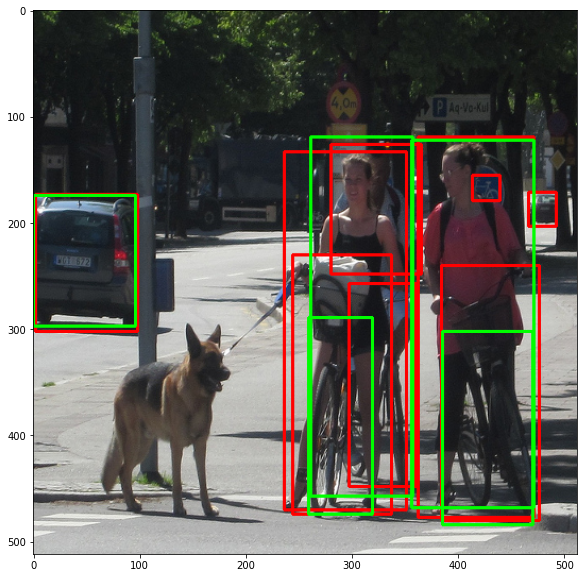

In [ ]:
img = imgg[0].permute(1,2,0)
plt.figure(figsize=(10  ,10))
plt.imshow(img)
bboximg = img.numpy().copy()
anno[0]['boxes'] = anno[0]['boxes'].squeeze(0)
anno[0]['labels'] = anno[0]['labels'].squeeze(0)
nms = {}
nms['1'] = 'person'
nms['2'] = 'bicycle'
nms['3'] = 'car'
for annot in anno[0]['boxes']:
  xmin = int(annot[0].item())
  ymin = int(annot[1].item())
  xmax = int(annot[2].item())
  ymax = int(annot[3].item())
  cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (255,0, 0), 2)

for i in range(len(predictions[0]['boxes'])):
  if predictions[0]['scores'][i] >= 0.85:
    box = predictions[0]['boxes'][i]
    xmin = int(box[0].item())
    ymin = int(box[1].item())
    xmax = int(box[2].item())
    ymax = int(box[3].item())

  cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (0, 255,0), 2)

plt.imshow(bboximg)
labels = [nms[str(x.item())] for x in anno[0]['labels']]
print(labels)

#ResNet50+FPN+FasterRCNN training

In [ ]:

model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True);
num_classes = 4 
in_features = model1.roi_heads.box_predictor.cls_score.in_features
model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:

num_classes = 4
model1.to(device)
params = [p for p in model1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


num_epochs = 5
for epoch in range(num_epochs):
  train_one_epoch(model1, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model1, val, device=device)
  

Epoch: [0]  [  0/276]  eta: 0:13:44  lr: 0.000002  loss: 2.5358 (2.5358)  loss_classifier: 1.5640 (1.5640)  loss_box_reg: 0.8485 (0.8485)  loss_objectness: 0.0715 (0.0715)  loss_rpn_box_reg: 0.0518 (0.0518)  time: 2.9859  data: 1.9050  max mem: 3743
Epoch: [0]  [275/276]  eta: 0:00:00  lr: 0.000500  loss: 0.8647 (1.2303)  loss_classifier: 0.2532 (0.5035)  loss_box_reg: 0.4650 (0.6362)  loss_objectness: 0.0425 (0.0534)  loss_rpn_box_reg: 0.0296 (0.0372)  time: 0.8285  data: 0.0319  max mem: 4011
Epoch: [0] Total time: 0:04:00 (0.8710 s / it)
creating index...
index created!
Test:  [ 0/12]  eta: 0:00:26  model_time: 0.4095 (0.4095)  evaluator_time: 0.0529 (0.0529)  time: 2.1909  data: 1.7243  max mem: 4011
Test:  [11/12]  eta: 0:00:00  model_time: 0.3510 (0.3329)  evaluator_time: 0.0444 (0.0449)  time: 0.8671  data: 0.4850  max mem: 4991
Test: Total time: 0:00:10 (0.8755 s / it)
Averaged stats: model_time: 0.3510 (0.3329)  evaluator_time: 0.0444 (0.0449)
Accumulating evaluation results..

In [ ]:
model = model1

In [ ]:
dataiter = iter(val)
imgg, anno = dataiter.next()
images = [imgg[i].to(device) for i in range(len(imgg))]
model.eval()
predictions = model1(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['bicycle', 'car', 'car', 'car', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


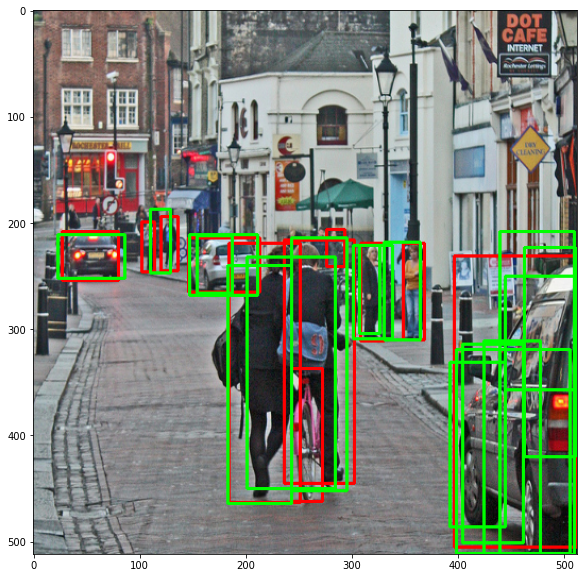

In [ ]:
img = imgg[0].permute(1,2,0)
plt.figure(figsize=(10  ,10))
plt.imshow(img)
bboximg = img.numpy().copy()
anno[0]['boxes'] = anno[0]['boxes'].squeeze(0)
anno[0]['labels'] = anno[0]['labels'].squeeze(0)
nms = {}
nms['1'] = 'person'
nms['2'] = 'bicycle'
nms['3'] = 'car'
for annot in anno[0]['boxes']:
  xmin = int(annot[0].item())
  ymin = int(annot[1].item())
  xmax = int(annot[2].item())
  ymax = int(annot[3].item())
  cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (255,0, 0), 2)

for i in range(len(predictions[0]['boxes'])):
  if predictions[0]['scores'][i] >= 0.70:
    box = predictions[0]['boxes'][i]
    xmin = int(box[0].item())
    ymin = int(box[1].item())
    xmax = int(box[2].item())
    ymax = int(box[3].item())

  cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (0, 255,0), 2)

plt.imshow(bboximg)
labels = [nms[str(x.item())] for x in anno[0]['labels']]
print(labels)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available

#our dataset has three classes only - background, person, car, bicycle
num_classes = 4

#move model to the right device
#model.to(device)

#construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)
#and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

#let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)
  

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available

#our dataset has three classes only - background, person, car, bicycle
num_classes = 4

#move model to the right device
#model.to(device)

#construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
#and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

#let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer,train, device, epoch, print_freq=300)
 #update the learning rate
  lr_scheduler.step()
 #evaluate on the test dataset
  evaluate_(model, val, device=device)
  